In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.training import train
from utils.quantization import optimization_step, quantize, initial_scales

torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

In [ ]:
LEARNING_RATE = 1e-4  # learning rate for all possible weights
HYPERPARAMETER_T = 0.15  # hyperparameter for quantization

# Create data iterators

In [4]:
batch_size = 512

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

# Model

In [6]:
from get_densenet import get_model

In [7]:
model, loss, optimizer = get_model(learning_rate=LEARNING_RATE)

# load pretrained model, accuracy ~48%
model.load_state_dict(torch.load('../vanilla_densenet_small/model.pytorch_state'))

#### keep copy of full precision kernels

In [8]:
# copy almost all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[1]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

#### initial quantization 

In [9]:
# scaling factors for each quantized layer
initial_scaling_factors = []

In [10]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[1]['params']]

In [11]:
for k, k_fp in zip(all_kernels, all_fp_kernels):
    
    # choose initial scaling factors 
    w_p_initial, w_n_initial = initial_scales(k_fp.data)
    initial_scaling_factors += [(w_p_initial, w_n_initial)]
    
    # do quantization, this uses hyperparameter 't'
    k.data = quantize(k_fp.data, w_p_initial, w_n_initial, t=HYPERPARAMETER_T)

#### parameter updaters

In [12]:
# optimizer for updating only all_fp_kernels
optimizer_fp = optim.Adam(all_fp_kernels, lr=LEARNING_RATE)

In [13]:
# optimizer for updating only scaling factors
optimizer_sf = optim.Adam([
    Variable(torch.FloatTensor([w_p, w_n]).cuda(), requires_grad=True) 
    for w_p, w_n in initial_scaling_factors
], lr=LEARNING_RATE)

# Train

In [14]:
n_epochs = 8
n_batches = ceil(train_size/batch_size)

# total number of batches in the train set
n_batches

196

In [15]:
%%time
def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(
        model, loss, x_batch, y_batch, 
        optimizer_list=[optimizer, optimizer_fp, optimizer_sf],
        t=HYPERPARAMETER_T
    )
all_losses = train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator,
    n_epochs=n_epochs, steps_per_epoch=n_batches, n_validation_batches=40
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  3.723 3.360  0.187 0.279  0.420 0.545  251.510
1  3.175 2.991  0.274 0.338  0.543 0.609  244.953
2  3.010 3.071  0.304 0.330  0.580 0.599  245.122
3  2.920 3.000  0.322 0.340  0.596 0.616  244.498
4  2.871 3.067  0.330 0.327  0.605 0.608  243.611
5  2.827 2.922  0.337 0.345  0.615 0.625  244.056
6  2.790 2.934  0.346 0.341  0.622 0.627  244.391
7  2.765 2.806  0.349 0.368  0.628 0.642  246.159
CPU times: user 26min 20s, sys: 6min 11s, total: 32min 31s
Wall time: 32min 44s


# Loss/epoch plots

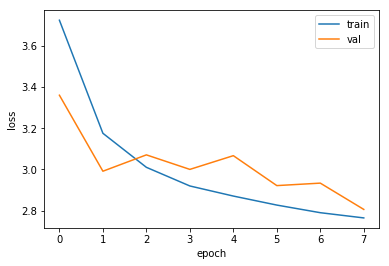

In [16]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

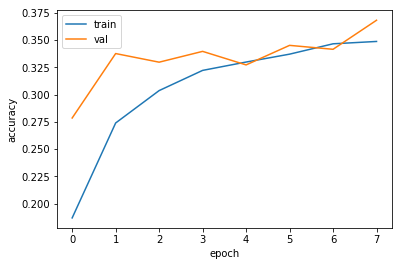

In [17]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

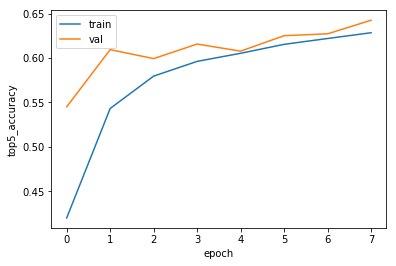

In [18]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [19]:
model.cpu();
torch.save(model.state_dict(), 'model_ternary_quantization.pytorch_state')